In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Part A: Classification Problem**

In [ ]:
import os
os.chdir('/content/drive/MyDrive/CZ4042')

In [ ]:
import time
import math

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [ ]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

## **Preprocessing Data**

In [ ]:
df = pd.read_csv('./full.csv') 
df['label'] = df['filename'].str.split('_').str[-2]
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,label
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803,neg
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572,neg
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824,neg
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389,neg
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966,neg


In [ ]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

## **Split and scale dataset**

In [ ]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

# **Q1.**

**Design a feedforward deep neural network (DNN) which consists of** 

- **an input layer, three hidden
layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid
activation function.**
- **Use a mini-batch gradient descent with ‘adam’ optimizer with learning rate of 0.001, and batch size = 256.** 
- **Apply dropout of probability 0.2 to each of the hidden layers.**

####**a) Use the training dataset to train the model for 100 epochs. Implement early stopping with patience of 3.**

In [ ]:
# defining hyperparameters
l_r = 0.001
epochs = 100
batch_size = 256
num_neurons = 128
drop_out = 0.2

In [ ]:
# create the model
starter_model = keras.Sequential([
        Dense(num_neurons, activation='relu'),
        Dropout(drop_out),
        Dense(num_neurons, activation='relu'),
        Dropout(drop_out),
        Dense(num_neurons, activation='relu'),
        Dropout(drop_out),
        Dense(1, activation='sigmoid')])
opt = keras.optimizers.Adam(learning_rate=l_r)

The early stopping callback will have the monitor of "val_loss" which will use the validation_data loss (here is the test_ds) to decide to stop at which epoch.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
starter_model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [ ]:
# train the model
history = starter_model.fit(X_train_scaled, y_train,
                            epochs=epochs,
                            verbose = 2,
                            batch_size=batch_size,
                            callbacks=[callback],
                            validation_data=(X_test_scaled,y_test))

Epoch 1/100
499/499 - 4s - loss: 0.6897 - binary_accuracy: 0.5361 - val_loss: 0.6844 - val_binary_accuracy: 0.5547 - 4s/epoch - 9ms/step
Epoch 2/100
499/499 - 3s - loss: 0.6832 - binary_accuracy: 0.5525 - val_loss: 0.6813 - val_binary_accuracy: 0.5579 - 3s/epoch - 7ms/step
Epoch 3/100
499/499 - 3s - loss: 0.6801 - binary_accuracy: 0.5608 - val_loss: 0.6800 - val_binary_accuracy: 0.5622 - 3s/epoch - 7ms/step
Epoch 4/100
499/499 - 3s - loss: 0.6774 - binary_accuracy: 0.5658 - val_loss: 0.6761 - val_binary_accuracy: 0.5681 - 3s/epoch - 7ms/step
Epoch 5/100
499/499 - 3s - loss: 0.6742 - binary_accuracy: 0.5722 - val_loss: 0.6736 - val_binary_accuracy: 0.5725 - 3s/epoch - 7ms/step
Epoch 6/100
499/499 - 3s - loss: 0.6701 - binary_accuracy: 0.5804 - val_loss: 0.6709 - val_binary_accuracy: 0.5785 - 3s/epoch - 6ms/step
Epoch 7/100
499/499 - 3s - loss: 0.6668 - binary_accuracy: 0.5851 - val_loss: 0.6678 - val_binary_accuracy: 0.5830 - 3s/epoch - 7ms/step
Epoch 8/100
499/499 - 5s - loss: 0.6634 -

####**b) Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots. Explain the use of early stopping in this question.**

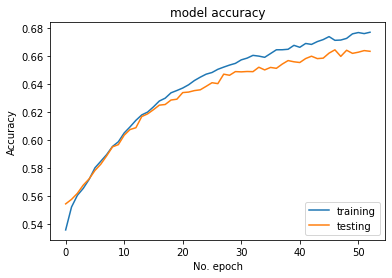

In [ ]:
# plot train and test accuracies curves
plt.plot(history.history['binary_accuracy'], label='training')
plt.plot(history.history['val_binary_accuracy'], label='testing')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.title("model accuracy")
plt.legend(loc="lower right")
plt.show()

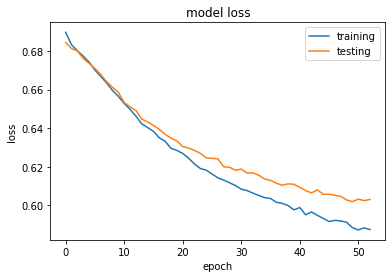

In [ ]:
# plot train and test losses curves
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='testing')    
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("model loss")
plt.legend(loc='best')
plt.show()

The model performs better on both training and test data when the number of epochs trained increases, which means that the accuracy increases and the loss decreases. Overall, the performance on test data is poorer than training data (higher accuracy and less loss). It is expected that there is a generalization gap between training and test data with the better performance on training data. However, the gap between the two curves for both accuracy and loss seems increased when the model is trained more epochs. It may suggest that the model is prone to overfitting.

The EarlyStopping callback is introduced to stop model training when the validation loss doesn't decrease after specified epochs (in our case, it is 3). The loss is not improved as it has coverage and the model started overfitting. Therefore, the callback helps to avoid overfitting model.